In [2]:
include("DG_Functions.jl")
include("Specific_DG_Functions.jl")
include("DG_Methods.jl")
include("Differentiation.jl")

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


grad (generic function with 1 method)

In [5]:
function dLegendreP(k,x)
    k<=K_max || throw(DomainError())
    return array2poly(symbolic_diff(Leg_coeffs[k+1]),x)
end

function dLegendreP(k)
    k<=K_max || throw(DomainError())
    return array2poly(symbolic_diff(Leg_coeffs[k+1]))
end

function dh(k,f_number,x)
    f_number<=k || throw(DomainError())
    return array2poly(symbolic_diff((DG_coeffs[k])[f_number]),x)
end

function dh(k,f_number)
    f_number<=k || throw(DomainError())
    return array2poly(symbolic_diff((DG_coeffs[k])[f_number]))
end

function dv(k::Int, level::Int, place::Int, f_number::Int, x::Real)
	if level==0 # At the base level, we are not discontinuous, and we simply
                # use Legendre polynomials up to degree k-1 as a basis
        return 2*dLegendreP(f_number-1,2*x-1)*sqrt(2.0)
	else
        return (1<<(level))*dh(k, f_number, (1<<level)*x - (2*place-1)) * (2.0)^(level/2)
        # Otherwise we use an appropriately shifted, scaled, and normalized
		# DG function
	end
end

function dv(k::Int, level::Int, place::Int, f_number::Int)
    return (xs::Real -> dv(k,level,place,f_number,xs))
end

function dV{D,T<:Real}(i::Int, k::Int, level::NTuple{D,Int}, 
    place::CartesianIndex{D}, f_number::CartesianIndex{D}, xs::AbstractArray{T})

    ans = one(eltype(xs))
    for j = 1:D
        if j == i
            ans *= dv(k, level[j], place[j], f_number[j], xs[j])
        else
            ans *= v(k, level[j], place[j], f_number[j], xs[j])
        end
    end
    return ans
end

function dV{D}(i, k, level::NTuple{D,Int}, 
                place::CartesianIndex{D}, f_number::CartesianIndex{D})
    return (xs::AbstractArray{Real} -> dV(i, k, level, place, f_number, xs))
end

function inner_product1D(f::Function, g::Function, lvl::Int, place::Int)
    xmin = (place-1)/(1<<(pos(lvl-1)))
	xmax = (place)/(1<<(pos(lvl-1)))
	h = (x-> f(x)*g(x))
    (val, err) = hquadrature(h, xmin, xmax; reltol=1e-8, abstol=1e-8, maxevals=0)
	return val 
end
#don't need to do anything numerically here, I don't think

function symbolic_diff{T<:Real}(v::Array{T})
	n=length(v)
    k=div(n,2)
	ans = zeros(T,n)
	for i in 1:n
		if i<k
			ans[i] = i*v[i+1]
		elseif i > k && i<2k
			ans[i] = (i-k) * v[i+1]
		else
			ans[i]=0
		end
	end
	return ans
end
#working

function legendreDlegendre(f_number1::Int, f_number2::Int)
	return inner_product(Leg_coeffs[f_number1],symbolic_diff(Leg_coeffs[f_number2]))
end 


function hDh(k::Int, f_number1::Int, f_number2::Int)
	return inner_product(DG_coeffs[k][f_number1], symbolic_diff(DG_coeffs[k][f_number2]))
end

function vDv(k::Int, lvl1::Int, place1::Int, f_number1::Int, lvl2::Int, place2::Int, f_number2::Int)
	if lvl1 == lvl2
		if lvl1 == 0
			return 2*legendreDlegendre(f_number1, f_number2)
		end
		if place1 == place2
			return hDh(k, f_number1, f_number2)*(1<<pos(lvl1))
		end
		return 0.0
	end
	if lvl1 < lvl2
		if lvl1 == 0
            return inner_product1D(v(k,0,1,f_number1), dv(k,lvl2,place2,f_number2), lvl2, place2)
		end
		if (1<<(lvl2-lvl1))*place1 >= place2 && (1<<(lvl2-lvl1))*(place1-1) < place2
            #@show (lvl1, place1, lvl2, place2)
            return inner_product1D(v(k,lvl1,place1,f_number1), dv(k,lvl2,place2,f_number2), lvl2, place2)
		end
		return 0.0
    end
	return 0.0

end

function D_reconstruct_DG{D,T<:Real}(i::Int, k::Int,
                                coefficients::Dict{CartesianIndex{D}, Array{Array{Float64},D}}, x::Array{T})
    value = 0.0
    f_numbers= ntuple(i-> k ,D)
    for key in keys(coefficients)	#For every level that has coefficients
        level = ntuple(i->key[i]-1,D)	# Get the actual level corresponding to that CartesianIndex
        place = CartesianIndex{D}(ntuple(i->hat_index(x[i],level[i]),D))
        # Get the relevant place for our position x
		for f_number in CartesianRange(f_numbers)
            value += (coefficients[key])[CartesianIndex{D}(place)][f_number]*dV(i,k,level,place,f_number,x)
		end 
		#get the appropriate coefficient and evaluate the appropriate ϕ at x
    end
    return value	#return the sum of all the relevant hat functions at that place x
end



D_reconstruct_DG (generic function with 1 method)

In [188]:
#hier_coefficients_DG(3, dv(k,level,place,f_number), (level+1,))
hier_coefficients_DG(3, x->dv(3,3,3,3,x[1]), (3+1,))


function diff_basis_DG(k::Int, level::Int, place::Int, f_number::Int)
    dcoeffs = Array(Float64, (level+1,k))
    p = place
    for l in level:-1:0
        for f_n in 1:k
            dcoeffs[l+1,f_n]=vDv(k, l, p, f_n, level, place, f_number)
        end
        p = Int(ceil(p/2))
    end
    return dcoeffs
end

precomputed_diffs = Dict{NTuple{4,Int},Array{Float64,2}}()

for level in 0:7
    for place in 1:(1<<pos(level-1)) 
        for f_number in 1:4
            precomputed_diffs[(4,level,place,f_number)] = diff_basis_DG(4,level,place,f_number)
        end
    end
end

function dchange{D,T<:Real}(k::Int,i::Int,dcoeffs::Dict{CartesianIndex{D}, Array{Array{Float64},D}},c::T,
    lvl::NTuple{D,Int}, place::CartesianIndex{D}, f_number::CartesianIndex{D})
    p = place[i]
    for l in lvl[i]:-1:0
        lvl1= ntuple(j-> j==i?l+1:(lvl[j]+1) ,D)
        place1=ntuple(j-> j==i?p:place[j] ,D)
        for f_n in 1:k
            f_number1=ntuple(j-> j==i?f_n:f_number[j] ,D)
            dcoeffs[CartesianIndex{D}(lvl1)][CartesianIndex{D}(place1)][CartesianIndex{D}(f_number1)] += c*precomputed_diffs[(k,lvl[i],place[i],f_number[i])][l+1,f_n]

        end
        p = Int(ceil(p/2))
    end
end


function diff_coefficients_DG{D}(i::Int, k::Int,
                        coeffs::Dict{CartesianIndex{D}, Array{Array{Float64},D}})
    
    dcoeffs=deepcopy(coeffs)
    f_numbers= ntuple(i-> k, D)
    
    for key in keys(coeffs)
        ks = ntuple(i -> 1<<pos(key[i]-2), D) 
        for place in CartesianRange(ks)
            for f_number in CartesianRange(f_numbers)
                dcoeffs[key][place][f_number]=0
            end
        end
    end
    
    for key in keys(coeffs)
        level = ntuple(i-> key[i]-1,D)
        ks = ntuple(i -> 1<<pos(level[i]-1), D) 
        for place in CartesianRange(ks)
            for f_number in CartesianRange(f_numbers)
                c=coeffs[key][place][f_number]
                dchange(k,i,dcoeffs,c,level,place,f_number)
            end
        end
    end
    return dcoeffs
end
    

diff_coefficients_DG (generic function with 1 method)

In [56]:
testcoeffs=Dict{CartesianIndex{2},Array{Array{Float64}}}()
testcoeffs[(4,4)]=[(i==3&&j==3)?1.0:0.0 for i in 1:3] for j in 
dchange(3,1,testcoeffs, 1.0,
    (3,3), CartesianIndex{2}((3,3)), CartesianIndex{2}((3,3)))

LoadError: LoadError: syntax: extra token "for" after end of expression
while loading In[56], in expression starting on line 2

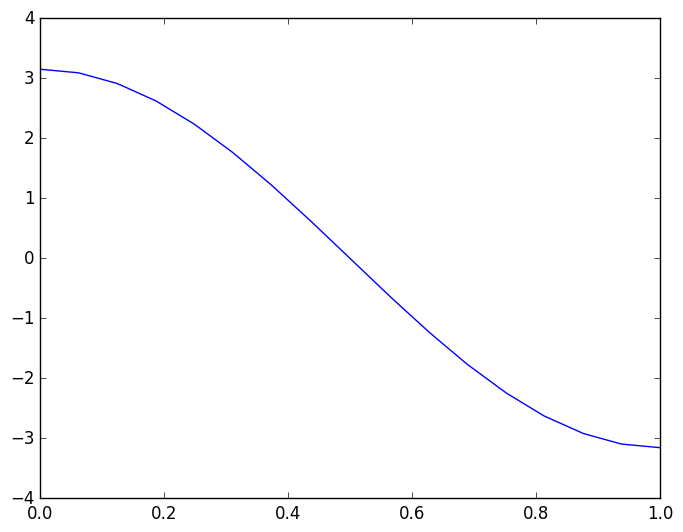

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x317192310>

In [4]:
#coeffs1=hier_coefficients_DG(3,(x->v(3,0,1,2,x[1])),(4,))
coeffs1=hier_coefficients_DG(3,(x->sin(pi*x[1])),(5,))
coeffsd=diff_coefficients_DG(1,3,coeffs1)
plotfunc1D(x->reconstruct_DG(3,coeffsd,[x[1]]))#-pi*cos(pi*x[1]))

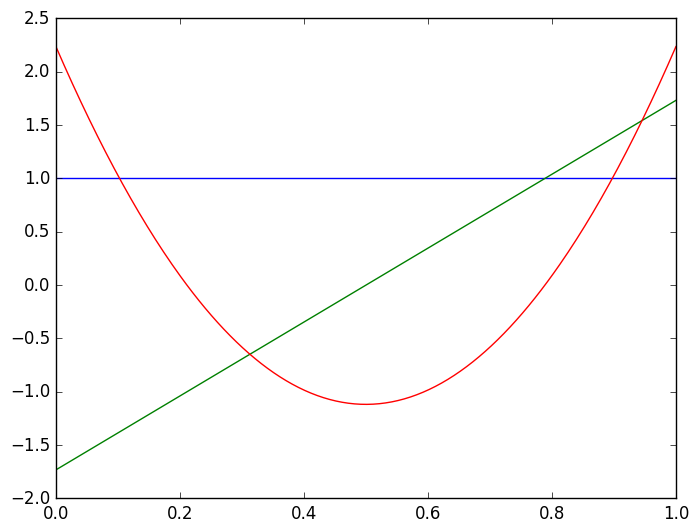

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3237d6710>

In [148]:
plotfunc1D(x->v(3, 0, 1, 1, x[1]))
plotfunc1D(x->v(3, 0, 1, 2, x[1]))
plotfunc1D(x->v(3, 0, 1, 3, x[1]))

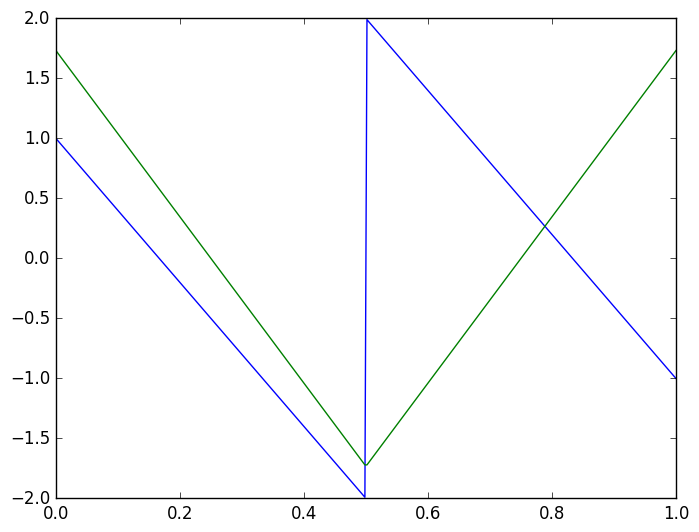

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x319f4b450>

In [46]:
plotfunc1D(x->v(2, 1, 1, 1, x[1]))
plotfunc1D(x->v(2, 1, 1, 2, x[1]))

In [25]:
println([vDv(2, 0, 1, 1, 0, 1, 1), vDv(2, 0, 1, 1, 0, 1, 2), vDv(2, 0, 1, 1, 1, 1, 1), vDv(2, 0, 1, 1, 1, 1, 2)])
println([vDv(2, 0, 1, 2, 0, 1, 1), vDv(2, 0, 1, 2, 0, 1, 2), vDv(2, 0, 1, 2, 1, 1, 1), vDv(2, 0, 1, 2, 1, 1, 2)])
println([vDv(2, 1, 1, 1, 0, 1, 1), vDv(2, 1, 1, 1, 0, 1, 2), vDv(2, 1, 1, 1, 1, 1, 1), vDv(2, 1, 1, 1, 1, 1, 2)])
println([vDv(2, 1, 1, 2, 0, 1, 1), vDv(2, 1, 1, 2, 0, 1, 2), vDv(2, 1, 1, 2, 1, 1, 1), vDv(2, 1, 1, 2, 1, 1, 2)])



[0.0,3.464101615137754,-6.0,0.0]
[0.0,0.0,1.4056967293496148e-16,6.000000000000001]
[0.0,0.0,0.0,3.4641016151377535]
[0.0,0.0,0.0,0.0]


In [48]:
[(vDv(2, div(i-1,2),1, 2-i%2, div(j-1,2), 1, 2-j%2)) for i in 1:4, j in 1:4]^2

4x4 Array{Float64,2}:
 0.0  0.0  4.86948e-16  7.10543e-15
 0.0  0.0  0.0          4.86948e-16
 0.0  0.0  0.0          0.0        
 0.0  0.0  0.0          0.0        

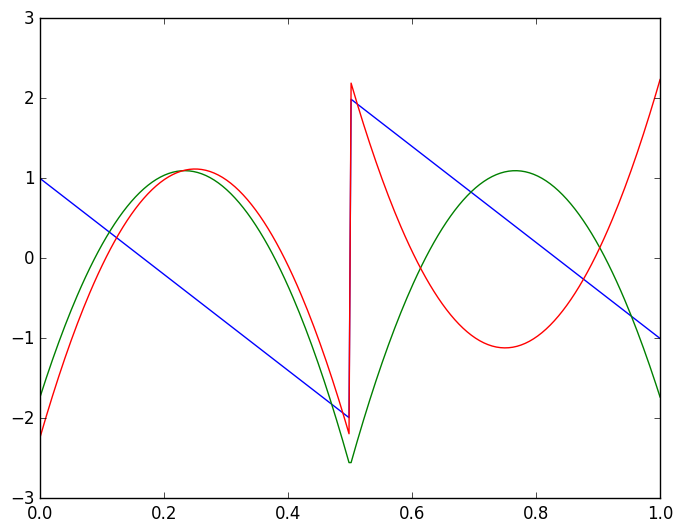

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x323a0f850>

In [149]:
plotfunc1D(x->v(3, 1, 1, 1, x[1]))
plotfunc1D(x->v(3, 1, 1, 2, x[1]))
plotfunc1D(x->v(3, 1, 1, 3, x[1]))

In [133]:
coeffs1D=hier_coefficients_DG(4,(x->cos(pi*x[1]+2)),(3,))

Dict{CartesianIndex{1},Array{Array{Float64,N},1}} with 3 entries:
  CartesianIndex{1}((3,)) => Array{Float64,N}[[-1.272546795244578e-5,0.00067566…
  CartesianIndex{1}((2,)) => Array{Float64,N}[[0.0006450315017004216,0.01372334…
  CartesianIndex{1}((1,)) => Array{Float64,N}[[-0.578876720880193,0.29212415615…

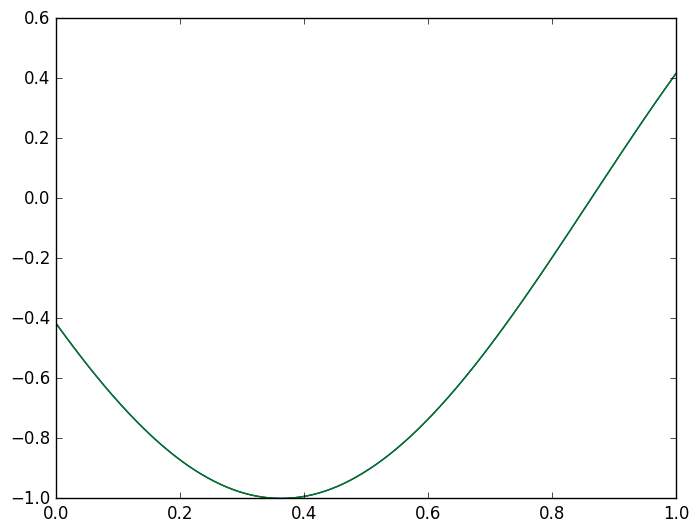

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x326af2510>

In [136]:
plotfunc1D(x->reconstruct_DG(4, coeffs1D, [x[1]]))
plotfunc1D(x-> cos(pi*x[1]+2))

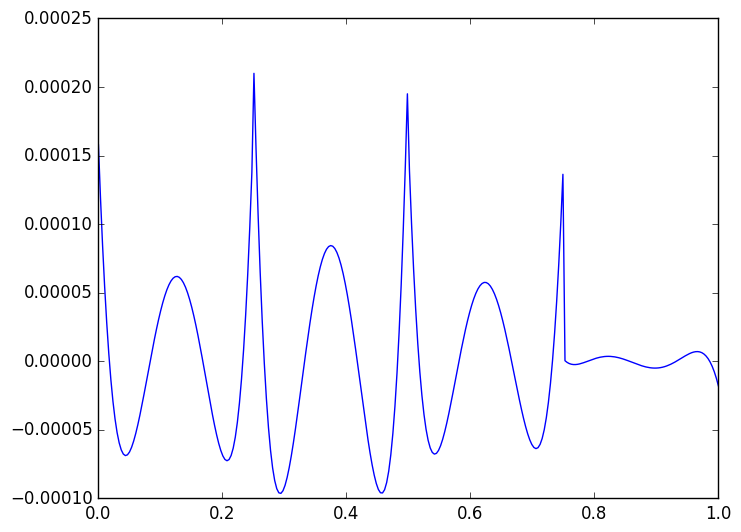

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x326d1ca90>

In [137]:
plotfunc1D(x->reconstruct_DG(4, coeffs1D, [x[1]])-cos(pi*x[1]+2))

dcoeffs1D=diff_coefficients_DG(1,4,coeffs1D)
@show dcoeffs1D

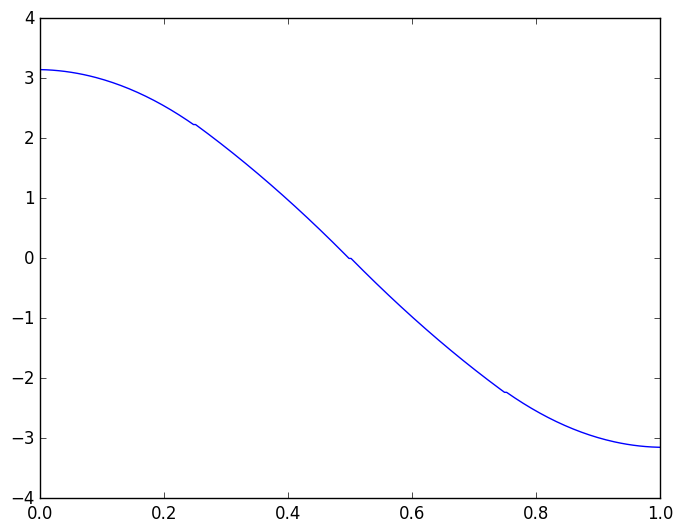

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x325d4fb90>

In [190]:
plotfunc1D(x->reconstruct_DG(4, dcoeffs1D, [x[1]]))

In [203]:
scoeffs2D=sparse_coefficients_DG(4,(x->sin(pi*x[1]+x[2])),3,2)
dscoeffs2D=diff_coefficients_DG(1,4,scoeffs2D)

Dict{CartesianIndex{2},Array{Array{Float64,N},2}} with 10 entries:
  CartesianIndex{2}((1,3)) => 1x2 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((3,1)) => 2x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((3,2)) => 2x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((4,1)) => 4x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((1,2)) => 1x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((1,1)) => 1x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((2,1)) => 1x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((2,3)) => 1x2 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((2,2)) => 1x1 Array{Array{Float64,N},2}:…
  CartesianIndex{2}((1,4)) => 1x4 Array{Array{Float64,N},2}:…

In [212]:
function redplotfunc2D(f::Function)
    xs=linspace(0,1,250)'
    ys=linspace(0,1,250)
    zs=[f((x,y)) for x in xs, y in ys]
    surf=plot_surface(xs,ys,zs,color = "red")
end

redplotfunc2D (generic function with 1 method)

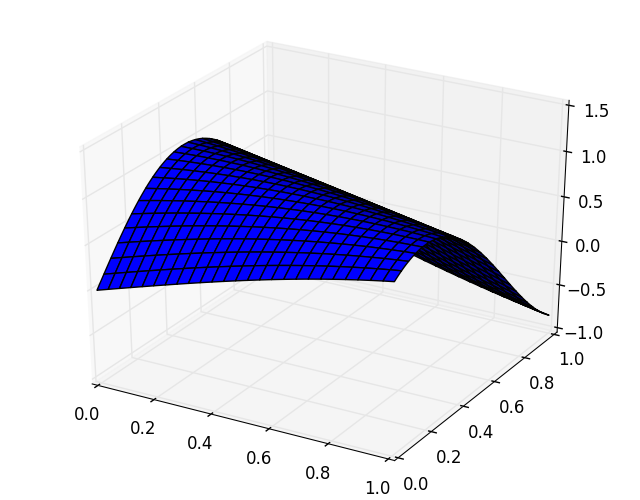

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x328e1f750>

In [216]:
plotfunc2D(x-> reconstruct_DG(4,scoeffs2D,[x[1], x[2]]))

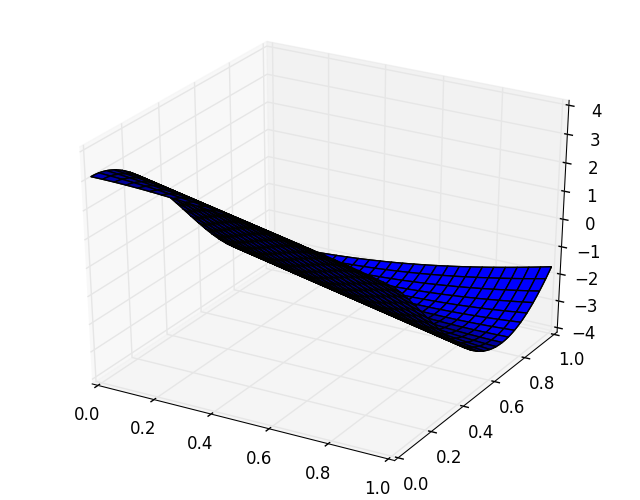

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x329425a90>

In [215]:
plotfunc2D(x-> reconstruct_DG(4,dscoeffs2D,[x[1], x[2]]))
redplotfunc2D(x-> pi*cos(pi*x[1]+x[2]))

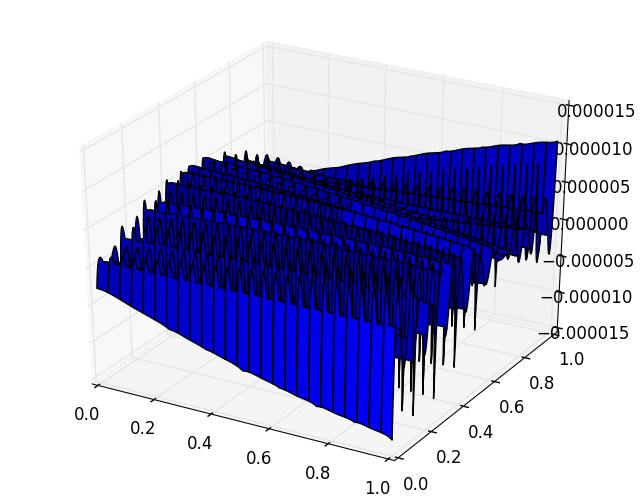

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x326e87350>

In [206]:
plotfunc2D(x-> reconstruct_DG(4,scoeffs2D,[x[1], x[2]])-sin(pi*x[1]+x[2]))

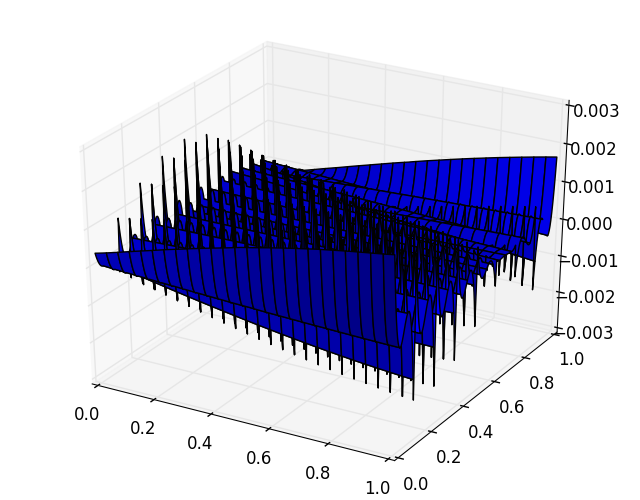

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x327cdef50>

In [207]:
plotfunc2D(x-> reconstruct_DG(4,dscoeffs2D,[x[1], x[2]])-pi*cos(pi*x[1]+x[2]))